## 使用TensorFlow的基本步骤
以使用LinearRegression来预测房价为例。
- 使用RMSE(均方根误差)评估模型预测的准确率
- 通过调整超参数来提高模型的预测准确率

In [1]:
from __future__ import print_function

import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

/Users/kevin/.virtualenvs/py36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
# 加载数据集
california_housing_df = pd.read_csv("https://download.mlcc.google.cn/mledu-datasets/california_housing_train.csv", sep=",")

In [3]:
# 将数据打乱
california_housing_df = california_housing_df.reindex(np.random.permutation(california_housing_df.index))
# 替换房价的单位为k
california_housing_df['median_house_value'] /=1000.0
print("california house dataframe: \n", california_housing_df)  # 根据pd设置，只显示10条数据，以及保留小数点后一位

california house dataframe: 
        longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
840       -117.1      32.7                29.0       1429.0           293.0   
15761     -122.4      37.8                52.0       3260.0          1535.0   
2964      -117.8      34.1                23.0       7079.0          1381.0   
5005      -118.1      33.8                36.0       1074.0           188.0   
9816      -119.7      36.5                29.0       1702.0           301.0   
...          ...       ...                 ...          ...             ...   
1864      -117.3      34.7                28.0       1932.0           421.0   
6257      -118.2      34.1                11.0       1281.0           418.0   
4690      -118.1      34.1                52.0       1282.0           189.0   
6409      -118.3      33.9                44.0       1103.0           265.0   
11082     -121.0      38.7                 5.0       5743.0          1074.0   

       population  ho

### 检查数据

In [4]:
# 使用pd的describe方法来统计一些信息
california_housing_df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0
mean,-119.6,35.6,28.6,2643.7,539.4,1429.6,501.2,3.9,207.3
std,2.0,2.1,12.6,2179.9,421.5,1147.9,384.5,1.9,116.0
min,-124.3,32.5,1.0,2.0,1.0,3.0,1.0,0.5,15.0
25%,-121.8,33.9,18.0,1462.0,297.0,790.0,282.0,2.6,119.4
50%,-118.5,34.2,29.0,2127.0,434.0,1167.0,409.0,3.5,180.4
75%,-118.0,37.7,37.0,3151.2,648.2,1721.0,605.2,4.8,265.0
max,-114.3,42.0,52.0,37937.0,6445.0,35682.0,6082.0,15.0,500.0


### 构建模型
我们将在这个例子中预测中位房价，将其作为学习的标签，使用房间总数作为输入特征。

#### 第1步：定义特征并配置特征列
为了把数据导入TensorFlow，我们需要指定每个特征包含的数据类型。我们主要使用以下两种类型：
- 分类数据： 一种文字数据。
- 数值数据：一种数字（整数或浮点数）数据或希望视为数字的数据。

在TF中我们使用**特征列**的结构来表示特征的数据类型。特征列仅存储对特征数据的描述，不包含特征数据本身。

In [5]:
# 定义输入特征
kl_feature = california_housing_df[['total_rooms']]

# 配置房间总数为数值特征列
feature_columns = [tf.feature_column.numeric_column('total_rooms')]

[_NumericColumn(key='total_rooms', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None)]


#### 第2步： 定义目标

In [6]:
#  定义目标标签
targets = california_housing_df['median_house_value']

**梯度裁剪**是在应用梯度值之前设置其上限，梯度裁剪有助于确保数值稳定性，防止梯度爆炸。

#### 第3步：配置线性回归器

In [7]:
# 使用Linear Regressor配置线性回归模型，使用GradientDescentOptimizer优化器训练模型
kl_optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.0000001)
# 使用clip_gradients_by_norm梯度裁剪我们的优化器，梯度裁剪可以确保我们的梯度大小在训练期间不会变得过大，梯度过大会导致梯度下降失败。
kl_optimizer = tf.contrib.estimator.clip_gradients_by_norm(kl_optimizer, 5.0)

# 使用我们的特征列和优化器配置线性回归模型
house_linear_regressor = tf.estimator.LinearRegressor(feature_columns=feature_columns, optimizer=kl_optimizer)

#### 第4步：定义输入函数
要将数据导入LinearRegressor，我们需要定义一个输入函数，让它告诉TF如何对数据进行预处理，以及在模型训练期间如何批处理、随机处理和重复数据。
首先我们将Pandas特征数据转换成NumPy数组字典，然后利用Dataset API构建Dataset对象，拆分数据为batch_size的批数据，以按照指定周期数(num_epochs)进行重复，**注意：**如果默认值num_epochs=None传递到repeat()，输入数据会无限期重复。
shuffle: Bool, 是否打乱数据
buffer_size: 指定shuffle从中随机抽样的数据集大小

In [8]:
def kl_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    """使用单个特征训练房价预测模型
    Args:
        features: 特征DataFrame
        targets: 目标DataFrame
        batch_size: 批大小
        shuffle: Bool. 是否打乱数据
    Return:
        下一个数据批次的元组(features, labels)
    """
    # 把pandas数据转换成np.array构成的dict数据
    features = {key: np.array(value) for key, value in dict(features).items()}
    
    # 构建数据集，配置批和重复次数、
    ds = Dataset.from_tensor_slices((features, targets))  # 数据大小 2GB 限制
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    # 打乱数据
    if shuffle:
        ds = ds.shuffle(buffer_size=10000)  # buffer_size指随机抽样的数据集大小
    
    # 返回下一批次的数据
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

**注意：** 更详细的输入函数和Dataset API参考：[TF Developer's Guide](https://www.tensorflow.org/programmers_guide/datasets)

#### 第5步：训练模型
在linear_regressor上调用train()来训练模型

In [9]:
_ = house_linear_regressor.train(input_fn=lambda: kl_input_fn(kl_feature, targets), steps=100)

#### 第6步：评估模型
**注意：**训练误差可以衡量训练的模型与训练数据的拟合情况，但**不能**衡量模型泛化到新数据的效果，我们需要拆分数据来评估模型的泛化能力。

In [10]:
# 只做一次预测，所以把epoch设为1并关闭随机
prediction_input_fn = lambda: kl_input_fn(kl_feature, targets, num_epochs=1, shuffle=False)

# 调用predict进行预测
predictions = house_linear_regressor.predict(input_fn=prediction_input_fn)

# 把预测结果转换为numpy数组
predictions = np.array([item['predictions'][0] for item in predictions])

# 打印MSE和RMSE
mean_squared_error = metrics.mean_squared_error(predictions, targets)
root_mean_squared_error = math.sqrt(mean_squared_error)

print("均方误差 %0.3f" % mean_squared_error)
print("均方根误差: %0.3f" % root_mean_squared_error)


均方误差 56367.025
均方根误差: 237.417


In [11]:
min_house_value = california_housing_df['median_house_value'].min()
max_house_value = california_housing_df['median_house_value'].max()
min_max_diff = max_house_value- min_house_value

print("最低中位房价: %0.3f" % min_house_value)
print("最高中位房价: %0.3f" % max_house_value)
print("中位房价最低最高差值: %0.3f" % min_max_diff)
print("均方根误差：%0.3f" % root_mean_squared_error)

最低中位房价: 14.999
最高中位房价: 500.001
中位房价最低最高差值: 485.002
均方根误差：237.417


由此结果可以看出模型的效果并不理想，我们可以使用一些基本的策略来降低误差。

In [12]:
calibration_data = pd.DataFrame()
calibration_data["predictions"] = pd.Series(predictions)
calibration_data["targets"] = pd.Series(targets)
calibration_data.describe()

,predictions,targets
count,17000.0,17000.0
mean,0.1,207.3
std,0.1,116.0
min,0.0,15.0
25%,0.1,119.4
50%,0.1,180.4
75%,0.2,265.0
max,1.9,500.0


In [13]:
# 我们可以可视化数据和我们学到的线，
sample = california_housing_df.sample(n=300) # 得到均匀分布的sample数据df

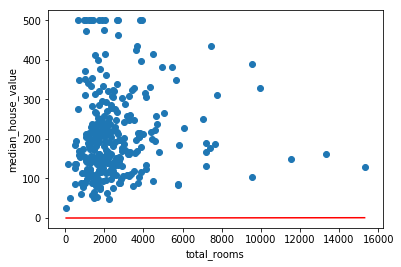

In [14]:
# 得到房屋总数的最小最大值
x_0 = sample["total_rooms"].min()
x_1 = sample["total_rooms"].max()

# 获得训练后的最终权重和偏差
weight = house_linear_regressor.get_variable_value('linear/linear_model/total_rooms/weights')[0]
bias = house_linear_regressor.get_variable_value('linear/linear_model/bias_weights')

# 计算最低最高房间数（特征）对应的房价（标签）
y_0 = weight * x_0 + bias
y_1 = weight * x_1 +bias

# 画图
plt.plot([x_0,x_1], [y_0,y_1],c='r')
plt.ylabel('median_house_value')
plt.xlabel('total_rooms')

# 画出散点图
plt.scatter(sample["total_rooms"], sample["median_house_value"])

plt.show()

### 模型调参
以上代码封装调参

In [15]:
def train_model(learning_rate, steps, batch_size, input_feature="total_rooms"):
    """Trains a linear regression model of one feature.
    
    Args:
        learning_rate: A `float`, the learning rate.
        steps: A non-zero `int`, the total number of training steps. A training step
            consists of a forward and backward pass using a single batch.
        batch_size: A non-zero `int`, the batch size.
        input_feature: A `string` specifying a column from `california_housing_df`
            to use as input feature.
    """
    
    periods = 10
    steps_per_period = steps / periods

    my_feature = input_feature
    my_feature_data = california_housing_df[[my_feature]]
    my_label = "median_house_value"
    targets = california_housing_df[my_label]

    # Create feature columns.
    feature_columns = [tf.feature_column.numeric_column(my_feature)]
    
    # Create input functions.
    training_input_fn = lambda:kl_input_fn(my_feature_data, targets, batch_size=batch_size)
    prediction_input_fn = lambda: kl_input_fn(my_feature_data, targets, num_epochs=1, shuffle=False)
    
    # Create a linear regressor object.
    my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
    my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
    linear_regressor = tf.estimator.LinearRegressor(
            feature_columns=feature_columns,
            optimizer=my_optimizer
    )

    # Set up to plot the state of our model's line each period.
    plt.figure(figsize=(15, 6))
    plt.subplot(1, 2, 1)
    plt.title("Learned Line by Period")
    plt.ylabel(my_label)
    plt.xlabel(my_feature)
    sample = california_housing_df.sample(n=300)
    plt.scatter(sample[my_feature], sample[my_label])
    colors = [cm.coolwarm(x) for x in np.linspace(-1, 1, periods)]

    # Train the model, but do so inside a loop so that we can periodically assess
    # loss metrics.
    print("Training model...")
    print("RMSE (on training data):")
    root_mean_squared_errors = []
    for period in range (0, periods):
        # Train the model, starting from the prior state.
        linear_regressor.train(
                input_fn=training_input_fn,
                steps=steps_per_period
        )
        # Take a break and compute predictions.
        predictions = linear_regressor.predict(input_fn=prediction_input_fn)
        predictions = np.array([item['predictions'][0] for item in predictions])
        
        # Compute loss.
        root_mean_squared_error = math.sqrt(
                metrics.mean_squared_error(predictions, targets))
        # Occasionally print the current loss.
        print("    period %02d : %0.2f" % (period, root_mean_squared_error))
        # Add the loss metrics from this period to our list.
        root_mean_squared_errors.append(root_mean_squared_error)
        # Finally, track the weights and biases over time.
        # Apply some math to ensure that the data and line are plotted neatly.
        y_extents = np.array([0, sample[my_label].max()])
        
        weight = linear_regressor.get_variable_value('linear/linear_model/%s/weights' % input_feature)[0]
        bias = linear_regressor.get_variable_value('linear/linear_model/bias_weights')

        x_extents = (y_extents - bias) / weight
        x_extents = np.maximum(np.minimum(x_extents,
                                                                            sample[my_feature].max()),
                                                     sample[my_feature].min())
        y_extents = weight * x_extents + bias
        plt.plot(x_extents, y_extents, color=colors[period]) 
    print("Model training finished.")

    # Output a graph of loss metrics over periods.
    plt.subplot(1, 2, 2)
    plt.ylabel('RMSE')
    plt.xlabel('Periods')
    plt.title("Root Mean Squared Error vs. Periods")
    plt.tight_layout()
    plt.plot(root_mean_squared_errors)

    # Output a table with calibration data.
    calibration_data = pd.DataFrame()
    calibration_data["predictions"] = pd.Series(predictions)
    calibration_data["targets"] = pd.Series(targets)
    display.display(calibration_data.describe())

    print("Final RMSE (on training data): %0.2f" % root_mean_squared_error)

**练习1： 使RMSE不超过180**

Training model...
RMSE (on training data):
    period 00 : 225.63
    period 01 : 214.42
    period 02 : 204.04
    period 03 : 194.97
    period 04 : 186.60
    period 05 : 180.80
    period 06 : 175.66
    period 07 : 171.74
    period 08 : 168.96
    period 09 : 167.23
Model training finished.


,predictions,targets
count,17000.0,17000.0
mean,117.4,207.3
std,96.8,116.0
min,0.1,15.0
25%,64.9,119.4
50%,94.4,180.4
75%,139.9,265.0
max,1684.4,500.0


Final RMSE (on training data): 167.23


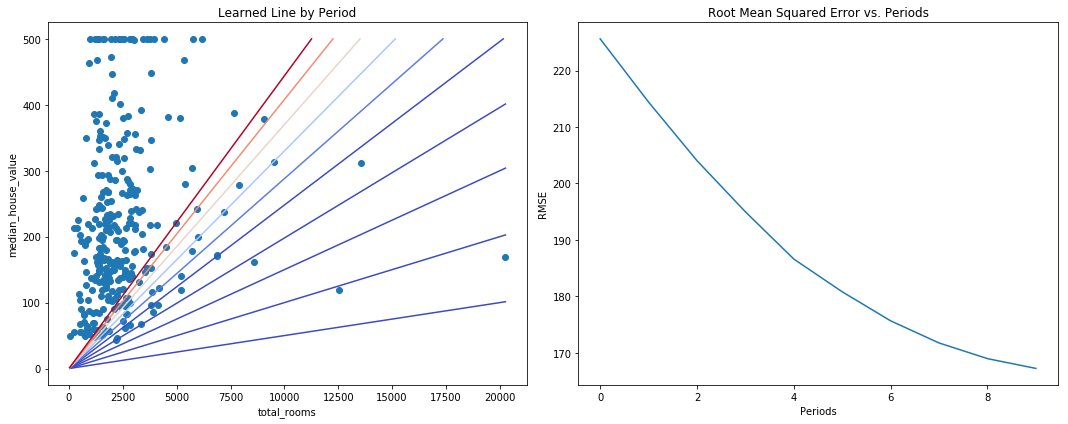

In [16]:
train_model(learning_rate=0.00002, steps=500, batch_size=5)

### 模型调参的启发法
> 不要死循规则

- 训练误差应该稳步减小，刚开始是急剧减小，最终应随着训练收敛达到平稳状态。
- 如果训练尚未收敛，尝试运行更长的时间。
- 如果训练误差减小速度过慢，则提高学习速率也许有助于加快其减小速度。
- 但有时如果学习速率过高，训练误差的减小速度反而会变慢。
- 如果训练误差变化很大，尝试降低学习速率。
- 较低的学习速率和较大的步数/较大的批量大小通常是不错的组合。
- 批量大小过小也会导致不稳定情况。不妨先尝试 100 或 1000 等较大的值，然后逐渐减小值的大小，直到出现性能降低的情况。

**练习2：尝试其他特征**
我们使用population特征替代。

Training model...
RMSE (on training data):
    period 00 : 222.79
    period 01 : 209.51
    period 02 : 198.00
    period 03 : 189.59
    period 04 : 182.78
    period 05 : 179.35
    period 06 : 177.30
    period 07 : 176.11
    period 08 : 175.97
    period 09 : 176.51
Model training finished.


,predictions,targets
count,17000.0,17000.0
mean,135.8,207.3
std,109.0,116.0
min,0.3,15.0
25%,75.0,119.4
50%,110.9,180.4
75%,163.5,265.0
max,3389.8,500.0


Final RMSE (on training data): 176.51


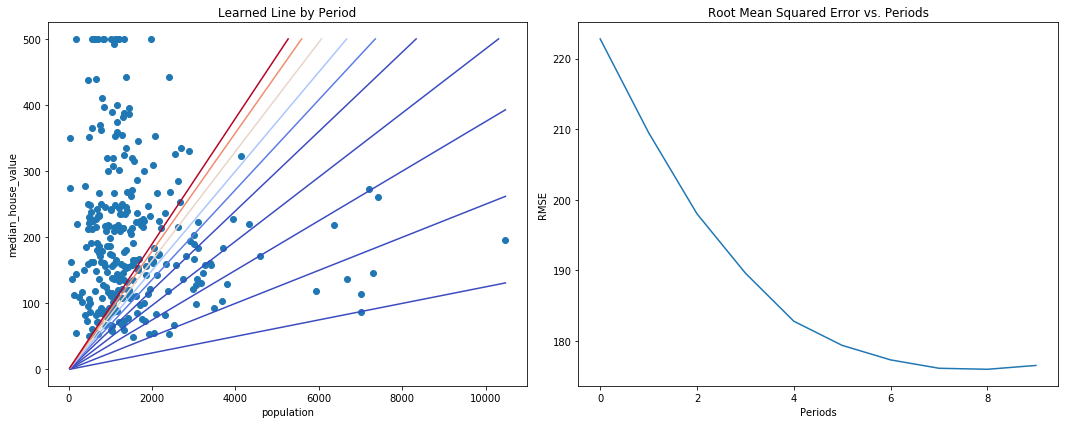

In [17]:
train_model(learning_rate=0.00005, steps=500, batch_size=5, input_feature="population")